## Import data

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB


# Load data
B = pd.read_csv('data/B (power transfer factor of each bus to each line).csv', sep=';').values
P_max = pd.read_csv('data\Maximum production of generating units.csv').values.flatten()
P_min = pd.read_csv('data\Minimum production of generating units.csv').values.flatten()
min_downtime = pd.read_csv('data\Minimum down time of generating units.csv').values.flatten()
min_uptime = pd.read_csv('data\Minimum up time of generating units.csv').values.flatten()
C_g = pd.read_csv('data\Production cost of generating units.csv').values.flatten()
C_gs = pd.read_csv('data\Start-up cost of generating units.csv').values.flatten()
ramp = pd.read_csv('data\Ramping rate of generating units.csv').values.flatten()
F = pd.read_csv('data\Transmission capacity of lines.csv').values

# Load wind data
W_cap = pd.read_csv('data/Capacity of wind farms.csv')
W1 = pd.read_csv('data\W1.csv', skiprows=3) 
W2 = pd.read_csv('data\W2.csv', skiprows=3)

# Scale wind data
W1 = np.array(W1.iloc[:,2]) * W_cap.values[0]
W2 = np.array(W2.iloc[:,2]) * W_cap.values[1]
W = np.vstack((W1, W2)).T

# Remove first row to fit with demand data
Wind = W[1:].T

# Load demand data
D = pd.read_csv('data\ConsumptionPerGridarea.csv', sep=';', decimal=',')
D = D.loc[D['GridCompany'].isin([131, 344, 16])]
D["HourDK"] = pd.to_datetime(D["HourDK"])
D = D.loc[D["HourDK"].dt.year == 2021]
D = D.pivot_table(index = "HourDK", columns = "GridCompany", values = "FlexSettledConsumption")

# Read and scale demand data
D_cap = pd.read_csv('data\Loads.csv')
D = (D/np.max(D, axis=0)) * D_cap.values.T
Demand = D.values.T




## Task 1: Understanding Unit Commitment and optimization model
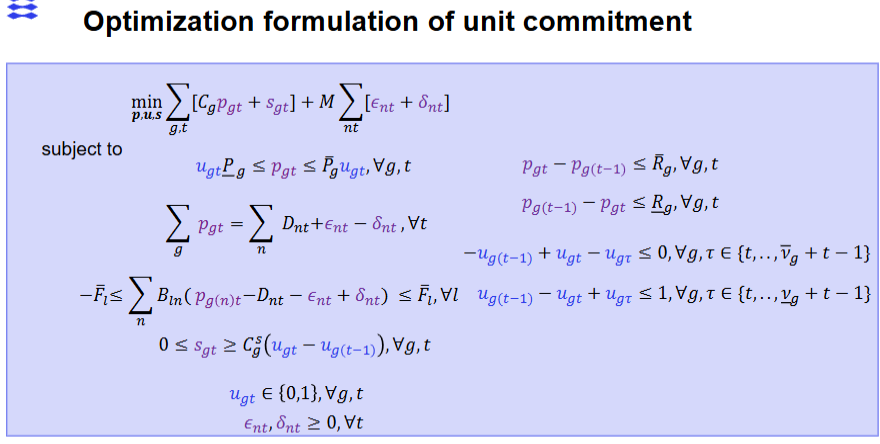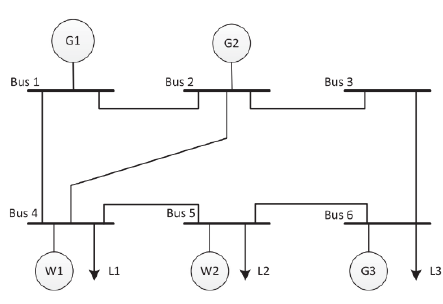

In [ ]:
G = len(P_max) # number of generators
L = len(F) # number of lines
N = B.shape[1] # number of nodes
G_n = [[0],[1],[],[],[],[2]]
W_n = [[ ],[],[],[0],[1],[]]
D_n = [[],[],[],[0],[1],[2]]
M = 1000 # Big M

def unit_commitment(Wind, Demand):
    #### Create model ####
    model = gp.Model()

    ### Parameters ###
    D, T = Demand.shape # number of time periods
    W = Wind.shape[0] # number of wind farms
    


    #### Decision variables ####


    # Production/bid in DA market
    p_g = model.addVars(G,T, lb = 0, vtype=GRB.CONTINUOUS, name="p_gt") # Power production in each generator in each time period
    p_w = model.addVars(W,T, vtype=GRB.CONTINUOUS, name="p_wt") # Power production in each wind farm in each time period
    u = model.addVars(G,T, vtype=GRB.BINARY, name="u_gt") # Binary variable for each generator in each time period
    s = model.addVars(G,T, lb = 0, vtype=GRB.CONTINUOUS, name="s_gt") # Start up cost for each generator in each time period

    # Slack variables
    delta   = model.addVars(N,T, lb = 0, vtype=GRB.CONTINUOUS, name="delta") # Slack variable for each time period for each node
    epsilon = model.addVars(N,T, lb = 0, vtype=GRB.CONTINUOUS, name="epsilon") # Slack variable for each time period for each node

    #### Objective function ####
    # Assume no production cost for wind
    model.setObjective(gp.quicksum(C_g[g] * p_g[g,t] + s[g,t] for g in range(G) for t in range(T))
                    + M * gp.quicksum(delta[n,t] + epsilon[n,t] for n in range(N) for t in range(T)), GRB.MINIMIZE)

    ### Constraints ###
    # Minimum production
    model.addConstrs(u[g,t] * P_min[g] <= p_g[g,t] for g in range(G) for t in range(T))

    # Maximum production
    model.addConstrs(p_g[g,t] <= u[g,t] * P_max[g] for g in range(G) for t in range(T))

    # Wind upper bound
    model.addConstrs(p_w[w,t] <= Wind[w,t] for w in range(W) for t in range(T))

    # Power balance
    model.addConstrs((gp.quicksum(p_g[g,t] for g in range(G)) + gp.quicksum(p_w[w,t] for w in range(W))== 
                    gp.quicksum(Demand[n,t] + epsilon[n,t] - delta[n,t] for n in range(D)) for t in range(T)), "Power balance")

    # Line flow
    model.addConstrs((gp.quicksum(B[l,n]*(p_g[g,t] + p_w[w,t] - D[d,t] - epsilon[n,t] + delta[n,t]) for n in range(N) for g in G_n[n] for w in W_n[n] for d in D_n[n] ) >= - F[l] for t in range(T) for l in range(L)), "Line flow")
    model.addConstrs((gp.quicksum(B[l,n]*(p_g[g,t] + p_w[w,t] - D[d,t] - epsilon[n,t] + delta[n,t]) for n in range(N) for g in G_n[n] for w in W_n[n] for d in D_n[n] ) <= F[l] for t in range(T) for l in range(L)), "Line flow")

    # Start-up cost
    model.addConstrs(s[g,t] >= C_gs[g] * (u[g,t] - u[g,t-1]) for g in range(G) for t in range(1,T))

    # Ramping constraint
    model.addConstrs(p_g[g,t] - p_g[g,t-1] <= ramp[g] for g in range(G) for t in range(1,T))
    model.addConstrs(p_g[g,t] - p_g[g,t-1] >= -ramp[g] for g in range(G) for t in range(1,T))

    # Minimum up time
    model.addConstrs(-u[g,t-1] + u[g,t] - u[g,tau] <= 0 for g in range(G) for t in range(1,T) for tau in range(t, min(min_uptime[g]+t-1, T-1)))

    # Minimum down time
    model.addConstrs(u[g,t-1] - u[g,t] + u[g,tau] <= 1 for g in range(G) for t in range(1,T) for tau in range(t, min(min_downtime[g]+t-1, T-1)))


    # Solve model
    model.setParam('OutputFlag', 0)
    model.optimize()

    # Extract results
    p_g = np.array([[p_g[g,t].x for t in range(T)] for g in range(G)])
    p_w = np.array([[p_w[w,t].x for t in range(T)] for w in range(W)])
    u = np.array([[u[g,t].x for t in range(T)] for g in range(G)])
    s = np.array([[s[g,t].x for t in range(T)] for g in range(G)])
    delta = np.array([[delta[n,t].x for t in range(T)] for n in range(N)])
    epsilon = np.array([[epsilon[n,t].x for t in range(T)] for n in range(N)])
    obj = model.objVal

    return p_g, p_w, u, s, delta, epsilon, obj

Run the model for each day in a year and save information

In [98]:
days = Demand.shape[1]//24
df_res = pd.DataFrame(index = np.arange(days*24))
objectives = []

for d in range(days):
    p_g, p_w, u, s, delta, epsilon, obj = unit_commitment(Wind[:,d*24:(d+1)*24], Demand[:,d*24:(d+1)*24])
    for g in range(p_g.shape[0]):
        df_res.loc[d*24:(d+1)*24-1, f"p_g_{g+1}"] = p_g[g].flatten()
        df_res.loc[d*24:(d+1)*24-1, f"u{g+1}"] = u[g].flatten()
        df_res.loc[d*24:(d+1)*24-1, f"s{g+1}"] = s[g].flatten()
    for w in range(p_w.shape[0]):
        df_res.loc[d*24:(d+1)*24-1, f"p_w_{w+1}"] = p_w[w].flatten()
        # df_res.loc[d*24:(d+1)*24 ,"delta"] = delta.flatten()

    objectives.append(obj)


C:\Users\jacob\AppData\Local\Temp\ipykernel_17560\3474892402.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model.addConstrs((gp.quicksum(B[l,n]*(p_g[g,t] + p_w[w,t] - D[d,t] - epsilon[n,t] + delta[n,t]) for n in range(N) for g in G_n[n] for w in W_n[n] for d in D_n[n] ) >= - F[l] for t in range(T) for l in range(L)), "Line flow")
C:\Users\jacob\AppData\Local\Temp\ipykernel_17560\3474892402.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model.addConstrs((gp.quicksum(B[l,n]*(p_g[g,t] + p_w[w,t] - D[d,t] - epsilon[n,t] + delta[n,t]) for n in range(N) for g in G_n[n] for w in W_n[n] for d in D_n[n] ) <= F[l] for t in range(T) for

<Axes: >

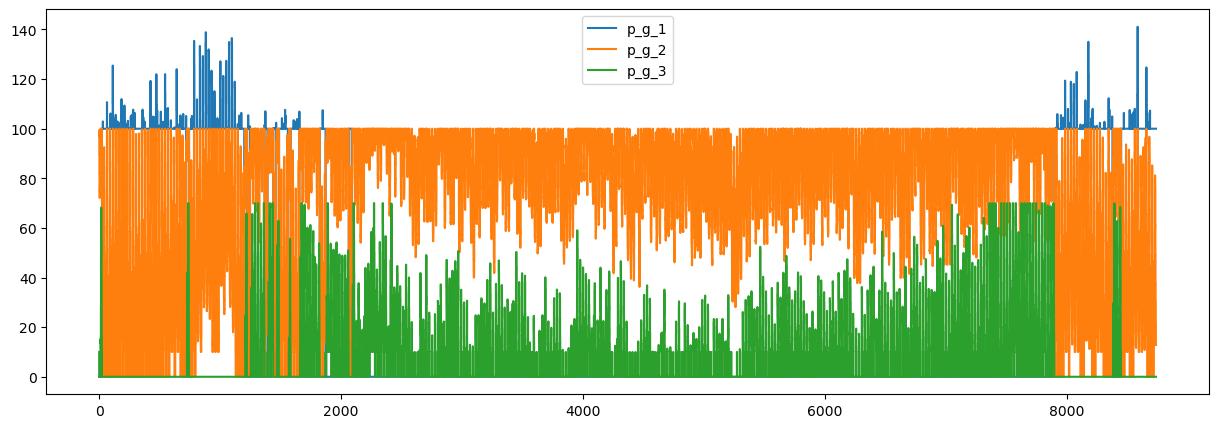

In [105]:
df_res[["p_g_1", "p_g_2", "p_g_3"]].plot(drawstyle="steps", figsize = (15,5))

## Task 2: Data preperation

In [141]:
x = Wind[:days*24,].T
y = df_res[[f"u{g+1}" for g in range(G)]].values

# Split into training, validation and test sets
train_test_fraction = 0.8
train_val_fraction = 0.8
n = len(x)
train_test_split = int(n * train_test_fraction)
train_val_split = int(train_test_split * train_val_fraction)

x_train = x[:train_test_split]
x_train_train = x[:train_val_split]
x_val = x_train[train_val_split:]
x_test = x[train_test_split:]

y_train = y[:train_test_split]
y_train_train = y[:train_val_split]
y_val = y_train[train_val_split:]
y_test = y[train_test_split:]


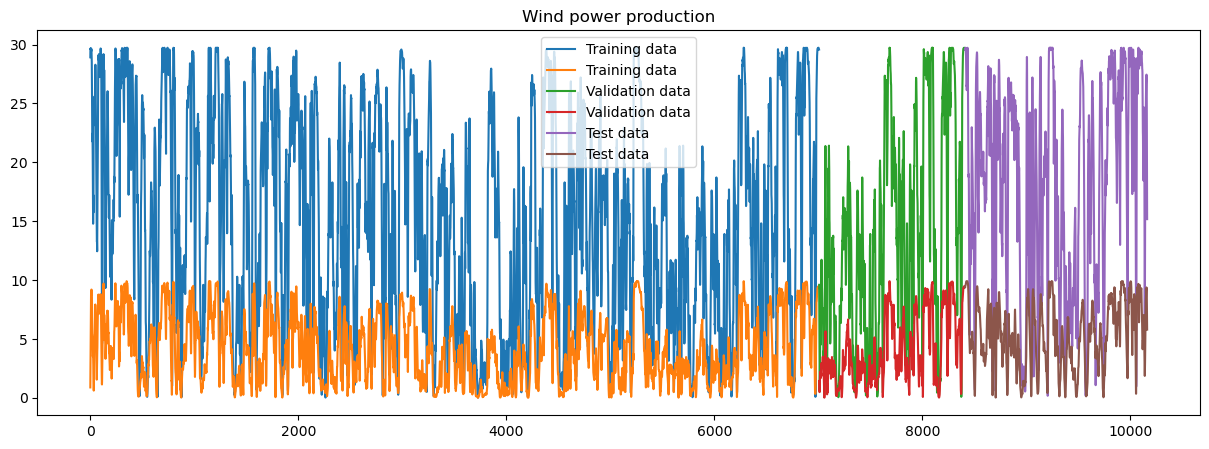

In [142]:
# Plot training, validatino and test data in sequence
plt.figure(figsize=(15,5))
plt.plot(x_train, label="Training data")
plt.plot(np.arange(len(x_train), len(x_train) + len(x_val), 1), x_val, label="Validation data")
plt.plot(np.arange(len(x_train) + len(x_val), len(x_train) + len(x_val) + len(x_test), 1), x_test, label="Test data")
plt.legend()
plt.title("Wind power production")
plt.show()


## Task 3: Train classifiers

In [147]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Train a decision tree classifier for each generator
classifiers = []
for g in range(G):
    clf = DecisionTreeClassifier()
    clf.fit(x_train_train, y_train_train[:,g])
    classifiers.append(clf)

# Predict on validation set
y_val_pred = np.zeros(y_val.shape)
for g in range(G):
    y_val_pred[:,g] = classifiers[g].predict(x_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.38159771754636235


## Task 4: Evaluate models